# Import the packages and define the functions

In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.stats import norm 
from scipy.stats import multivariate_normal
import time
import sys
import glob

flt_min = sys.float_info.min

%matplotlib inline

In [3]:
# define the function to load the pictures

def load_pic(name):
     files = glob.glob(name)
     ColorImgs = []
     for myFile in files:
          im = plt.imread(myFile)
          ColorImgs.append(im)
     
     return ColorImgs

In [4]:
# Convert the image data to (d*n) matrix where 'd' is 3 
# representing 'R', 'B', 'G' and 'n' is the number of pixels

def convert_data(data):
     # data should be [row,column,3] array
     nrow,ncolumn,rgb_numb = data.shape
     # rgb = 3, representing red, green, and blue

     # initialise the 3*n matrix
     mat = np.zeros((3,nrow*ncolumn))
     for i in range(3):
          mat[i,:] = data[:,:,i].reshape(1,nrow*ncolumn)
     
     return mat


In [5]:
# Define the function to calculate the probability 
# of multi-variable normal distribution

def calcGaussianProb(data,gaussMean,gaussCov):
     nDim,nData = data.shape
     d = len(data)
     # print(size)
     deter = np.linalg.det(gaussCov)
     # print(deter)

     norm_const = 1/((2*np.pi)**(d/2) * (deter**0.5))
     # print('hello ', norm_const)
     # print(gaussMean)
     x_mu = data.reshape(1,data.shape[0])-gaussMean
     # print(x_mu.shape)
     inv = np.linalg.inv(gaussCov)
     # print(inverse.shape)
     like=norm_const * np.exp(-0.5*(x_mu@inv@x_mu.transpose()))
    
     return like

In [6]:
# Define the function to fit the data to univariable gaussian 

def fitGaussianModel(data):
     # extract the dimension of the data
     nDim,nData = data.shape

     # calculate the mean of the input data
     meanData = np.mean(data, axis=1)

     # calculate the covariance of the input data
     covData = np.cov(data)

     return meanData, covData

In [7]:
# Calulate the probabilities of mixture gaussian 

def mixGaussian_prob(data, mixGauss):

     # extract the data from mixGauss
     curr_weight = mixGauss['weight']
     curr_means = mixGauss['mean']
     curr_cov = mixGauss['cov']

     numb_gaussian = curr_weight.shape[0]

     # initialise the probability
     prob = 0
     for i in range(numb_gaussian):
          prob = prob + curr_weight[i]*calcGaussianProb(data, curr_means[:,i], curr_cov[:,:,i])

     return prob

In [8]:
# define the function to show the figure

def show_image_pred(image, pred, tittle_image='N/A', tittle_pred='N/A'):
     # plot the figures
     f, (ax1, ax2) = plt.subplots(1, 2)

     # show the image
     ax1.imshow(image[0])
     ax1.set_title(tittle_image)

     # show the prediction
     ax2.imshow(pred)
     ax2.set_title(tittle_pred)

In [9]:
# # define the function to plot the confusion matrix
# # sourced from COMP0169: Machine Learning for Visual Computing - Coursework 1

# def true_positive(Y_test, y_pred):
#     mask = (Y_test == 1)
#     tp = (Y_test[mask] == y_pred[mask]).sum()
#     return tp.item()

# def true_negative(Y_test, y_pred):
#     mask = (Y_test == 0) | (Y_test == -1)
#     tn = (Y_test[mask] == y_pred[mask]).sum()
#     return tn.item()

# def false_negative(Y_test, y_pred):
#     mask = (y_pred == 0) | (y_pred == -1)
#     tn = (Y_test[mask] != y_pred[mask]).sum()
#     return tn.item()

# def false_positive(Y_test, y_pred):
#     mask = (y_pred == 1)
#     tn = (Y_test[mask] != y_pred[mask]).sum()
#     return tn.item()

# def plot_confusion_matrix(Y_test, y_pred):
#     tp = true_positive(Y_test, y_pred)
#     tn = true_negative(Y_test, y_pred)
#     fp = false_positive(Y_test, y_pred)
#     fn = false_negative(Y_test, y_pred)
#     cf = np.array([[tn, fp], [fn, tp]])
#     fig, ax = plt.subplots()
#     ax.matshow(cf, cmap=plt.cm.Blues)
#     for i in range(2):
#         for j in range(2):
#             c = cf[i,j]
#             ax.text(j, i, str(c), va='center', ha='center')
#     plt.xlabel('Prediction')
#     plt.ylabel('Target')
#     plt.show()

# Load the Training Apple pictures

In [10]:
# import the training pictures

ColorImgs_1 = load_pic("Apples_by_kightp_Pat_Knight_flickr.jpg")
ColorImgs_2 = load_pic("ApplesAndPears_by_srqpix_ClydeRobinson.jpg")
ColorImgs_3 = load_pic("bobbing-for-apples.jpg")

# Load the masks of Training Apple pictures

In [11]:
# import the ||MASK|| of training pictures

ColorImgs_1_mask = load_pic("Apples_by_kightp_Pat_Knight_flickr.png")
ColorImgs_2_mask = load_pic("ApplesAndPears_by_srqpix_ClydeRobinson.png")
ColorImgs_3_mask = load_pic("bobbing-for-apples.png")

# Data Processing

In [13]:
# convert the training image data into 3*n matrix

image_1 = convert_data(ColorImgs_1[0])
image_2 = convert_data(ColorImgs_2[0])
image_3 = convert_data(ColorImgs_3[0])

# stack the image data
data_row = np.hstack((image_1,image_2))
data_row = np.hstack((data_row,image_3))

In [15]:
# convert the marks of training image data into 3*n matrix

mask_1 = convert_data(ColorImgs_1_mask[0]) 
mask_2 = convert_data(ColorImgs_2_mask[0]) 
mask_3 = convert_data(ColorImgs_3_mask[0])

# stack the mark data
data_mask = np.hstack((mask_1,mask_2))
data_mask = np.hstack((data_mask, mask_3)) 

In [16]:
# combine the data_row and data_mask
data = data_row * data_mask

Sort the data into 'apple' and 'non-apple'

In [32]:
# sort the data into 'apple' and 'non-apple'
# initialise the list to store the indices of 'non-apple' pixel
indices = []
for i in range(data.shape[1]):
     if np.sum(data[:,i])==0:
          indices.append(i)

data_NonApple = data_row[:,indices]
data_Apple = np.delete(data,indices,axis=1)

# Gaussian Mixture Model (GMM)

Define the function to calculate the mixture gaussian log likelihood

In [34]:
def getMixGaussLogLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    logLike = 0;                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for cData in range(nData):                                                                         
        thisData = data[:, cData].reshape(data.shape[0],1)                                                                      
        # TO DO - calculate likelihood of this data point under mixture of                         
        # Gaussians model. Replace this                                                                
        # like = 1 

        temp = 0
        for i in range(mixGaussEst['k']):
            # own function calculate the prob
            temp = temp + mixGaussEst['weight'][i] * calcGaussianProb(thisData, mixGaussEst.get('mean')[:,i], mixGaussEst.get('cov')[:,:,i])
            # scipy multivariable_normal calculate the prob
            # print('prob is ', gaussain_prob_scipy(thisData, mixGaussEst.get('mean')[:,i], mixGaussEst.get('cov')[:,:,i]))
            # temp = temp + mixGaussEst['weight'][i] * gaussain_prob_scipy(thisData, mixGaussEst.get('mean')[:,i], mixGaussEst.get('cov')[:,:,i])

            # print(temp)

        # add to total log like                                                                        
        logLike = logLike + np.log(temp)   
        # print('loglike is ', logLike)                                                            
                                                                                                       
    return  logLike.item()                                                                       
                                                                                                       

In [35]:
# ---------------------------------------------

In [36]:
# # test
# from sklearn.mixture import GaussianMixture
# gm = GaussianMixture(n_components=2, random_state=0).fit(data_Apple.transpose())


In [37]:
# ---------------------------------------------

Define the function to fit the data to mixture gaussian distribution

In [38]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape


    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 100 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 800 + 1000 * np.random.uniform() * np.eye(nDims)
        

    # calculate current likelihood
    # TO DO - fill in this routine
    logLike = getMixGaussLogLike(data, mixGaussEst)
    # print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    nIter = 20;

    logLikeVec = np.zeros(shape=(2 * nIter))
    boundVec = np.zeros(shape=(2 * nIter))

    # fig, ax = plt.subplots(1, 1)

    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================

        for cData in range(nData):
            # TO DO (g) : fill in column of 'hidden' - calculate posterior probability that
            # this data point came from each of the Gaussians
            # replace this:
            # postHidden[:, cData] = 1/k

            thisData = data[:, cData].reshape(data.shape[0],1)
            r = np.zeros((k,1))
            for i in range(k):
                r[i,0]=mixGaussEst['weight'][i] * calcGaussianProb(thisData, mixGaussEst.get('mean')[:,i], mixGaussEst.get('cov')[:,:,i])

            sum_r = np.sum(r)
            postHidden[:,cData] = r.squeeze()/sum_r
            

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # TO DO (h):  Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian. Replace this:
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss,:])/np.sum(postHidden)
            
            
            # TO DO (i):  Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.  Replace this:
            mixGaussEst['mean'][:,cGauss] = (postHidden@data.transpose())[cGauss]/np.sum(postHidden,axis=1).squeeze()[cGauss]
            
            
            # TO DO (j):  Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            mixGaussEst['cov'][:,:,cGauss] = postHidden[cGauss,:]*(data-mixGaussEst['mean'][:,cGauss].reshape(data.shape[0],1))@(data-mixGaussEst['mean'][:,cGauss].reshape(data.shape[0],1)).transpose()/np.sum(postHidden,axis=1).squeeze()[cGauss]
            
            
            # draw the new solution
        # drawEMData2d(data, mixGaussEst)
        time.sleep(0.7)
        # fig.canvas.draw()

        # calculate the log likelihood
        logLike = getMixGaussLogLike(data, mixGaussEst)
        # print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))


    return mixGaussEst

Import the training data into GMM

In [ ]:
# define number of components to estimate
# considering red apples and green apples, so nGaussEst_Apple = 2
nGaussEst_Apple = 3

# fit the 'apple' data to mixture of Gaussians
mixGaussEst_Apple = fitMixGauss(data_Apple,nGaussEst_Apple)

In [41]:
# fit the 'non-apple' data to univariable Gaussian
meanData_NonApple, covData_NonApple = fitGaussianModel(data_NonApple)

In [42]:
# print(mixGaussEst_Apple['mean'][:,0])
# print(mixGaussEst_Apple['mean'][:,1])


In [43]:
# print(mixGaussEst_Apple['cov'][:,:,0])
# print(mixGaussEst_Apple['cov'][:,:,1])


In [44]:
# print(mixGaussEst_Apple['weight'][0])
# print(mixGaussEst_Apple['weight'][1])

In [45]:
# ----------------------------------------

In [46]:
# print(gm.means_)

# print(gm.covariances_)

# print(gm.weights_)

In [47]:
# ----------------------------------------

# Plot the pixel's posterior probability of the test data

Load the Test Apple pictures

In [71]:
# import the test pictures

ColorImgs_test_1 = load_pic("Apples_by_MSR_MikeRyan_flickr.jpg")
ColorImgs_test_2 = load_pic("audioworm-QKUJj2wmxuI-original.jpg")
ColorImgs_test_3 = load_pic("Bbr98ad4z0A-ctgXo3gdwu8-original.jpg")

In [52]:
# -------------------------------------------

In [53]:
# # test <<Scikit>>
# def mixGaussian_prob_sk(data, weight, mean, cov):

#      # extract the data from mixGauss
#      curr_weight = weight
#      curr_means = mean
#      curr_cov = cov

#      numb_gaussian = curr_weight.shape[0]

#      # initialise the probability
#      prob = 0
#      for i in range(numb_gaussian):
#           prob = prob + curr_weight[i]*calcGaussianProb(data, curr_means[i], curr_cov[i])

#      return prob

In [54]:
# -------------------------------------------

Generate each pixel's posterior probability of being 'apple' of the testing images

In [88]:
def posterior_apple(image):
     # define the priors for whether the pixel is 'apple' or 'non-apple'
     priorApple = 0.7
     priorNonApple = 0.3

     # extract the dimension of the image
     imY, imX, imZ = image.shape

     # initialise the posterior of being 'apple'
     post_Apple = np.zeros([imY,imX])

     for cY in range(imY):

          for cX in range(imX):
               # extract this pixel's data
               thisPixelData = np.double(image[cY,cX,:])
               thisPixelData = thisPixelData[:, np.newaxis]

               # calculate likelihood of this data given 'apple' model
               likeApple = mixGaussian_prob(thisPixelData, mixGaussEst_Apple)

               # calculate likelihood of this data given 'apple' model with <<Scikit>>
               # likeApple = mixGaussian_prob_sk(thisPixelData, gm.weights_, gm.means_, gm.covariances_)

               # calculate likelihood of this data given 'non-apple' model
               likeNonApple = calcGaussianProb(thisPixelData, meanData_NonApple, covData_NonApple)

               # priors using BAYES rule
               post_Apple[cY,cX] = likeApple*priorApple/(likeApple*priorApple+likeNonApple*priorNonApple)

     return post_Apple



In [89]:
# apply the testing images 
post_Apple_1 = posterior_apple(ColorImgs_test_1[0])
post_Apple_2 = posterior_apple(ColorImgs_test_2[0])
post_Apple_3 = posterior_apple(ColorImgs_test_3[0])

# Answer to the C

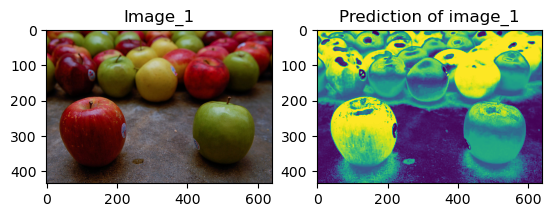

In [90]:
# plot the image and prediction of image_1

show_image_pred(ColorImgs_test_1, post_Apple_1,'Image_1','Prediction of image_1')

The posterior probability of 'red apple' is relatively higher than the which of 'green apple' and 'yellow apple'.

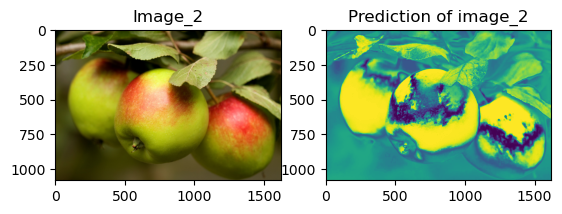

In [91]:
# plot the image and prediction of image_2

show_image_pred(ColorImgs_test_2, post_Apple_2,'Image_2','Prediction of image_2')

The result of this picture is not very good. For the middle apple, the red part has a low posterior probability while the red part of the right apple has a high posterior probability and the green part has a low posterior probability. 

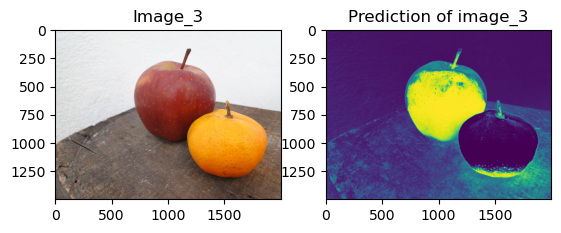

In [92]:
# plot the image and prediction of image_3

show_image_pred(ColorImgs_test_3,post_Apple_3,'Image_3','Prediction of image_3')

Large part of apple has high posterior probability, however, the edge of apple has a relatively low posterior probability and the bottom of orange has high posterior probability. 

# Answer to D

In [129]:
# create the function to apply the threshold to the posterior probability

def threshold_posterior(pred, threshold):
     temp_mat = pred.copy()
     for i in range(temp_mat.shape[0]):
          for j in range(temp_mat.shape[1]):
               if temp_mat[i,j]<threshold:
                    temp_mat[i,j]=0
               else:
                    temp_mat[i,j]=1

     return temp_mat

In [281]:
# define the function to calculate the parameters of ROC Curve

def para_ROC(actual, posterior):

     # initialise the TP rate and FP rate matrix
     mat = np.zeros((2,11))
     
     for _ in range(0,11,1):
          pred = threshold_posterior(posterior, _*0.1)
          
          # initialise the parameters
          TP = 0
          TN = 0
          FP = 0
          FN = 0

          for i in range(actual.shape[0]):
               for j in range(actual.shape[1]):
                    if actual[i,j]==1 and pred[i,j]==0:
                         FN += 1
                    elif actual[i,j]==1 and pred[i,j]==1:
                         TP += 1
                    elif actual[i,j]==0 and pred[i,j]==1:
                         FP += 1
                    else:
                         TN += 1

          # calculate the true positive rate
          true_positive_rate = TP/(TP+FN)

          # calculate the false positive rate
          false_positive_rate = FP/(FP+TN)

          mat[0,_]=true_positive_rate
          mat[1,_]=false_positive_rate
     
     return mat


In [276]:
# load the mask of the testing picture
ColorImgs_test_3_mask = load_pic('Bbr98ad4z0A-ctgXo3gdwu8-original.png')

In [282]:
# apply the thresholds of 0 to 1 with 0.1 increment

mat = para_ROC(ColorImgs_test_3_mask[0][:,:,0], post_Apple_3)

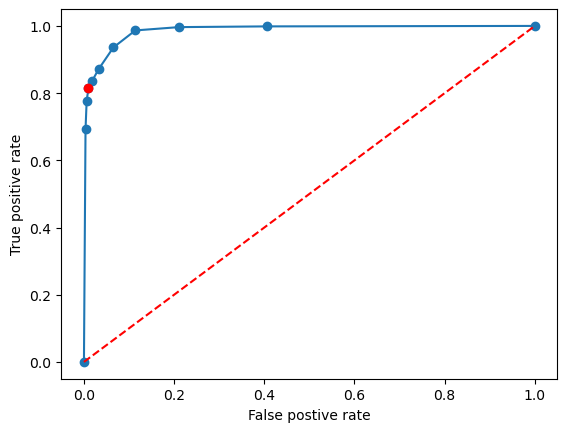

In [291]:
# plot the ROC Curve

x = mat[1,:]
y = mat[0,:]

plt.plot(x, y, '-o')
plt.plot([0,1], '--r')
plt.ylabel('True positive rate')
plt.xlabel('False postive rate')
plt.plot(x[7],y[7], 'or')
plt.show()

In this ROC Curve, the true posititve rate indicate the proportion of 'apple' pixels were correctly classified while the false positive rate indicated the proportion of 'non-apple' pixels that incorrectly classified. Therefore, to achieve a better classification of 'apple' pixels, the true positive rate is the higher the better and the false positive rate is the lower the better, which means the (0,1) is the ideal classification. In this case, the threshold of 0.7 is chosen (shown as the red dot) which has over 80% true positive rate and about 1% false positive rate.

Text(0.5, 1.0, 'Threshold of 0.7')

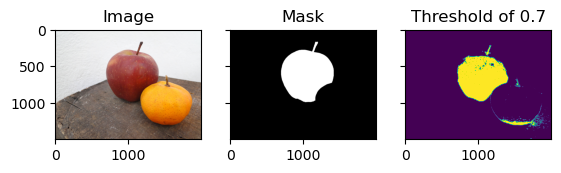

In [330]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='row')

# show the image
ax1.imshow(ColorImgs_test_3[0])
ax1.set_title('Image')

# show the prediction
ax2.imshow(ColorImgs_test_3_mask[0])
ax2.set_title('Mask')

# show the image
ax3.imshow(threshold_posterior(post_Apple_3, 0.7))
ax3.set_title('Threshold of 0.7')

When the threshold is 0.8 the prediction of the 'apple' pixels is very close to the ground truth except the edge of the apple was not shown and the bottom of the orange was shown.

# Answer to E

test extra pictures

In [251]:
# load the extra pictures

ColorImgs_extra_1 = load_pic('daniela-crucez-DpfXrAjlIro-unsplash.jpg')
ColorImgs_extra_2 = load_pic('robson-melo-H6VxhE_x-kE-unsplash.jpg')

ColorImgs_extra_1_mask = load_pic('daniela-crucez-DpfXrAjlIro-unsplash_mask.jpg')
ColorImgs_extra_2_mask = load_pic('robson-melo-H6VxhE_x-kE-unsplash_mask.jpg')

In [298]:
# normalise the pixels of ground truth to be 0 or 1

def normalise_mask(image_data):
     temp = image_data.copy()

     for i in range(temp.shape[0]):
          for j in range(temp.shape[1]):
               if temp[i,j] != 0:
                    temp[i,j]=1
     

     return temp

In [241]:
# apply the extra testing images

post_Apple_extra_1 = posterior_apple(ColorImgs_extra_1[0])
post_Apple_extra_2 = posterior_apple(ColorImgs_extra_2[0])


In [309]:
# apply the thresholds of 0 to 1 with 0.1 increment

mat_1 = para_ROC(normalise_mask(ColorImgs_extra_1_mask[0][:,:,0]), post_Apple_extra_1)
mat_2 = para_ROC(normalise_mask(ColorImgs_extra_2_mask[0][:,:,0]), post_Apple_extra_2)

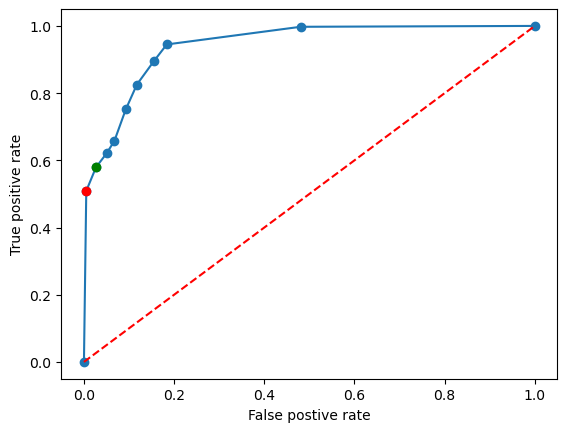

In [323]:
# plot the ROC Curve

x = mat_1[1,:]
y = mat_1[0,:]

plt.plot(x, y, '-o')
plt.plot([0,1], '--r')
plt.ylabel('True positive rate')
plt.xlabel('False postive rate')
plt.plot(x[9],y[9], 'or')
plt.plot(x[8],y[8], 'og')
plt.show()

From the ROC Curve, when the threshold is set to be 0.9 (shown as the red dot) the true positive rate is about 50% and the false positive rate is closed to 0. When the threshold is set to be 0.8 (shown as the green dot) the true positive rate is higher than the which of 0.9 threshold, but the false positive rate is also higher. More straightforward detail will be shown in the next figures 

Text(0.5, 1.0, 'Threshold_0.8')

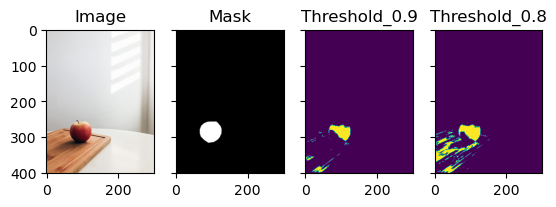

In [326]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey='row')

# show the image
ax1.imshow(ColorImgs_extra_1[0])
ax1.set_title('Image')

# show the prediction
ax2.imshow(ColorImgs_extra_1_mask[0])
ax2.set_title('Mask')

# show the prediction
ax3.imshow(threshold_posterior(post_Apple_extra_1, 0.9))
ax3.set_title('Threshold_0.9')

ax4.imshow(threshold_posterior(post_Apple_extra_1, 0.8))
ax4.set_title('Threshold_0.8')

From these figures, the difference between different thresholds are shown. If the threshold is 0.9 almost half of the apple is predicted. However, when the threshold is 0.8, the number of 'apple' pixels doesn't increase dramatically but more 'non-apple' pixels are shown.

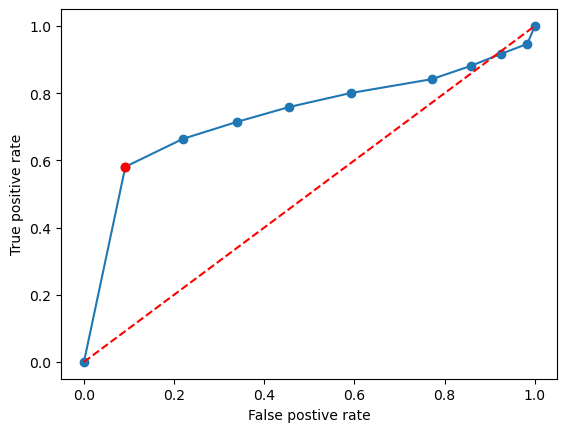

In [314]:
# plot the ROC Curve

x = mat_2[1,:]
y = mat_2[0,:]

plt.plot(x, y, '-o')
plt.plot([0,1], '--r')
plt.ylabel('True positive rate')
plt.xlabel('False postive rate')
plt.plot(x[9],y[9], 'or')
plt.show()

The threshold of 0.9 is chosen in the classification, however, the accuracy of this case of classification is not satisfying. The red dot in the ROC Curve shows that the true positive rate is only 58% while the false positive rate reaches to 9%.

Text(0.5, 1.0, 'Threshold_0.8')

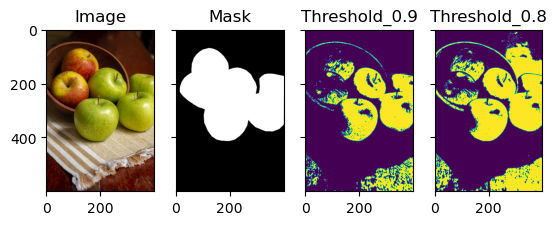

In [333]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey='row')

# show the image
ax1.imshow(ColorImgs_extra_2[0])
ax1.set_title('Image')

# show the prediction
ax2.imshow(ColorImgs_extra_2_mask[0])
ax2.set_title('Mask')

# show the image
ax3.imshow(threshold_posterior(post_Apple_extra_2, 0.9))
ax3.set_title('Threshold_0.9')

ax4.imshow(threshold_posterior(post_Apple_extra_2, 0.8))
ax4.set_title('Threshold_0.8')

From these figures, the classification of 0.9 threshold is better than the which of 0.8 threshold. In the 'Threshold_0.9' figure, four green apples are correctly classified while the prediction of the red apples is not correct. Besides, part of the table is incorrectly classified as 'apple' in 'Threshold_0.9'.

## Answer to the F:


The data set for the machine learning are basically seperated into training set, validation set, and test set. Training set is to provide the data to build up the algorithm. Validation set is to check the performance of the algorithm when applying a entirely different dataset than the training set. Validation set provide the chance to refine the algorithm by adjusting some hyperparameters. The test set is to test whether the algorithm work on the real data and check the accuracy of the algorithm.